In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# utils functions
def reduce_contrast(img):
    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(12,12))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    result = np.hstack((img, enhanced_img))
    return enhanced_img

def remove_red(img):
    # assign red channel to zeros
    img[:,:,2] = np.zeros([img.shape[0], img.shape[1]])
    return img

In [3]:
def analyze_video(path):
    cap = cv2.VideoCapture(path)
    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")

    timestamp = 0
    mean_intensity = []
    # Read until video is completed
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            mean_intensity.append(cv2.mean(gray)[0]) # grayscale is one dimensional so take the first element
            # Display the resulting frame
            # cv2.imshow('Frame',frame)

            # Press Q on keyboard to  exit
            # if cv2.waitKey(25) & 0xFF == ord('q'):
            #   break
            timestamp = timestamp + 1
        # Break the loop
        else: 
            break
    metadata = {
        'frame_count': cap.get(cv2.CAP_PROP_FRAME_COUNT),
        'fps': cap.get(cv2.CAP_PROP_FPS),
        'frame_width': cap.get(cv2.CAP_PROP_FRAME_WIDTH),   # float `width`
        'frame_height': cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height`
    }
    # When everything done, release the video capture object
    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()

    return [range(1, timestamp+1), mean_intensity, metadata]

def show(x, y, xlabel, ylabel, start=None, end=None):
    fig, ax = plt.subplots()
    ax.plot(x[start:end], y[start:end])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

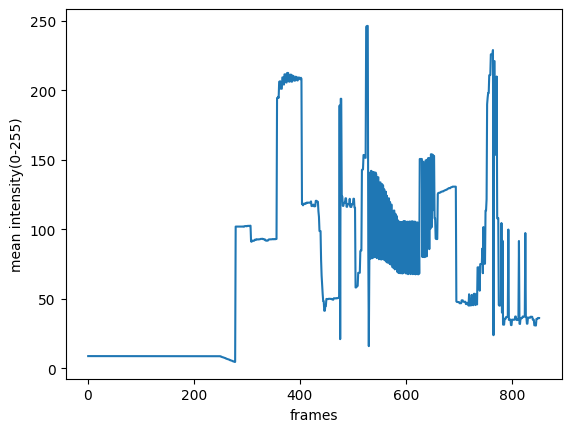

In [4]:
# plot mean gray intensity to frames
x, y, metadata = analyze_video('../videos/pokemon_deleted_scene.mp4')
show(x, y, 'frames', 'mean intensity(0-255)')

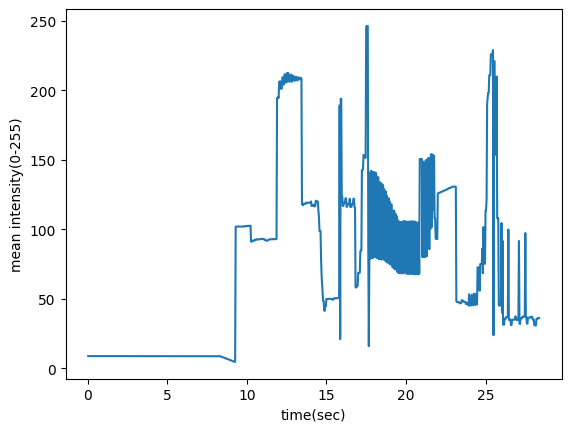

In [5]:
x_arr = np.array(x)
time = x_arr / metadata['fps']
show(time, y, 'time(sec)', 'mean intensity(0-255)')

In [6]:
diff = []
sd = np.std(y)
for i in range(len(y)-1):
    diff.append(1 if abs(y[i] - y[i+1]) > 30 else 0) # TODO: figure out tuning metrics
diff.append(0) # adjust shape for plotting
sd

61.550448471164486

In [7]:
# TODO: figure out tuning metrics


5 flashes detected at frame: 499


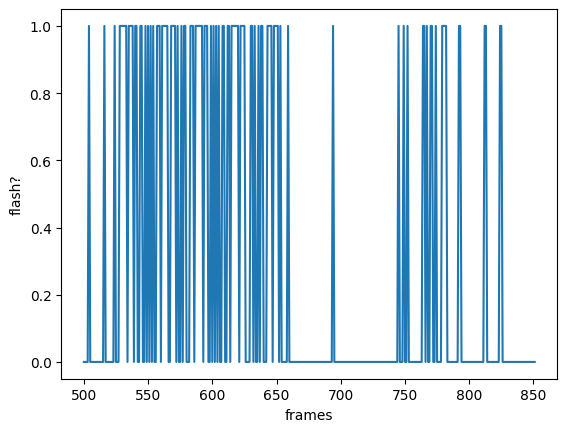

In [8]:
def detectUnsafeFlashes(intensity, fps, max_flashes=3):
    warning_count = 0
    for i in range(len(intensity) - fps):
        num_flash = np.sum(intensity[i:i+fps])
        if(num_flash > max_flashes):
            print(f"{num_flash} flashes detected at frame: {i}")
            warning_count = warning_count + 1
            break
    return warning_count, i

# get the starting frame of the 'unsafe' content
warning_count, starting_frame = detectUnsafeFlashes(diff, int(metadata['fps']), max_flashes=4)
show(x, diff, 'frames', 'flash?', starting_frame)

In [9]:
def write_video(warning_idx):
    cap = cv2.VideoCapture('../videos/pokemon_deleted_scene.mp4')
    out = cv2.VideoWriter('filtered_video.avi', 
                          cv2.VideoWriter_fourcc('M','J','P','G'), 
                          30, 
                          (int(metadata['frame_width']), int(metadata['frame_height'])))
    count = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            if(count > warning_idx):
                # do some censoring here
                frame = reduce_contrast(frame)
                frame = remove_red(frame)
            count = count + 1
            out.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [10]:
write_video(starting_frame)